# 1. Load all necessary modules

In [1]:
#!/usr/bin/env python
import os, argparse, glob, tempfile, shutil, warnings
import cv2
import numpy as np
import pandas as pd
#import tensorflow as tf
#from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
#import pytesseract
from paddleocr import PaddleOCR,draw_ocr
import openpyxl
from openpyxl import Workbook
from openpyxl.styles import Alignment

In [2]:
ocr = PaddleOCR(use_angle_cls=True, lang = 'en') ## Run only once to download all required files

[2023/12/15 16:49:09] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/user/brussel/105/vsc10520/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/user/brussel/105/vsc10520/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6

# 2. Import and read the climate data images

In [4]:
# Since this is just a trial version of the code, here we only import & read one of the test images
image = cv2.imread('example_image_after_preprocessing.jpg')

# Additionally, read a image with a template
#template= cv2.imread('form_82_13.jpg')

# 3. Load the table detection model

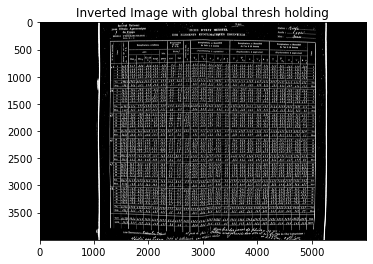

In [5]:
thresh,img_bin = cv2.threshold(image,128,255,cv2.THRESH_BINARY)
img_bin = 255-img_bin
plotting = plt.imshow(img_bin,cmap='gray')
plt.title("Inverted Image with global thresh holding")
plt.show()

In [6]:
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, np.array(image).shape[1]//150))
eroded_image = cv2.erode(img_bin, vertical_kernel, iterations=1)
vertical_lines = cv2.dilate(eroded_image, vertical_kernel, iterations=1)

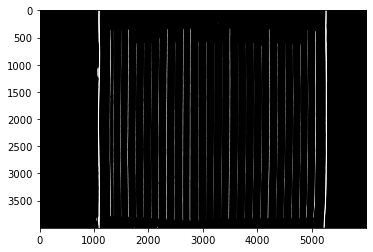

In [7]:
plt.imshow(vertical_lines, cmap = 'gray')


In [8]:

hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (np.array(image).shape[1]//150, 1))
image_2 = cv2.erode(img_bin, hor_kernel, iterations=1)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=1)

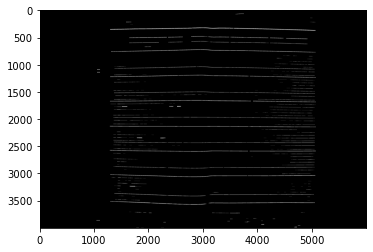

In [9]:
plt.imshow(horizontal_lines, cmap = 'gray')

In [10]:
vertical_horizontal_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
vertical_horizontal_lines = cv2.erode(~vertical_horizontal_lines, hor_kernel, iterations=2)

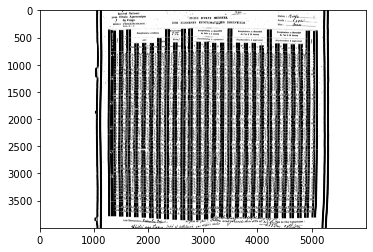

In [11]:
thresh, vertical_horizontal_lines = cv2.threshold(vertical_horizontal_lines,128,255, cv2.THRESH_BINARY)
b_image = cv2.bitwise_not(cv2.bitwise_xor(image,vertical_horizontal_lines))
plotting = plt.imshow(b_image,cmap='gray')
plt.show()

In [12]:
gray_image = cv2.cvtColor(vertical_horizontal_lines, cv2.COLOR_BGR2GRAY)

contours, hierarchy = cv2.findContours(gray_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

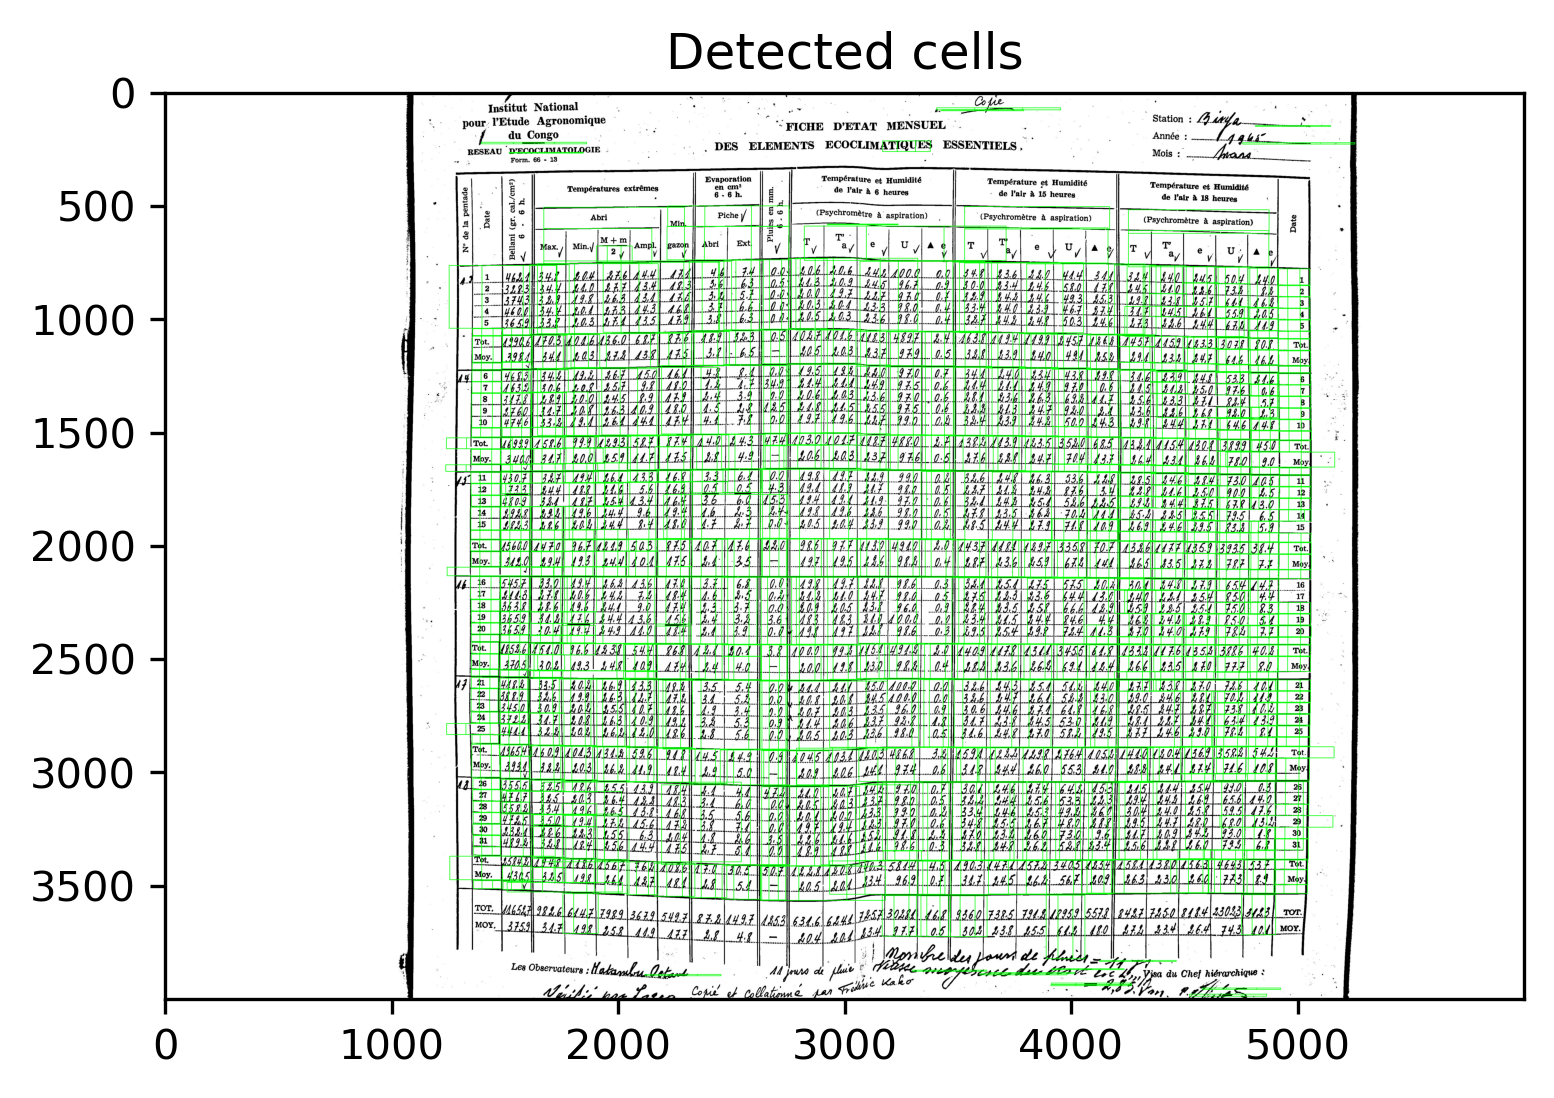

In [21]:
## Illustrate the detected cells
boxes = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if (w<1000 and h<500):
        image = cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
        boxes.append([x,y,w,h])
        
        # Crop each cell using the bounding rectangle coordinates
        ROI = image[y:y+h, x:x+w]
        cv2.imwrite('clipped.png', ROI)

        
plt.figure(dpi=300)
plotting = plt.imshow(image,cmap='gray')
plt.title("Detected cells")
plt.show()

### Side Note: Example of how the OCR works on a clipped image as done in the STEP 4

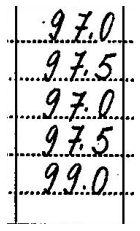

In [13]:
img = mpimg.imread('clipped100.png') # One of the clipped images from the STEP 4 Below

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [18]:
test_clipped_image_path = 'clipped100.png'

result = ocr.ocr(test_clipped_image_path, cls = True)


[2023/12/15 17:05:38] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.046004533767700195
[2023/12/15 17:05:38] ppocr DEBUG: cls num  : 5, elapsed : 0.04349637031555176
[2023/12/15 17:05:38] ppocr DEBUG: rec_res num  : 5, elapsed : 0.5687880516052246


[[[48.0, 1.0], [156.0, 3.0], [154.0, 53.0], [46.0, 50.0]], ('9.7.0.', 0.778980553150177)]
[[[45.0, 57.0], [154.0, 61.0], [152.0, 105.0], [43.0, 101.0]], ('9.7.5.', 0.8525647521018982)]
[[[42.0, 110.0], [154.0, 112.0], [152.0, 158.0], [41.0, 155.0]], ('9.F.0.', 0.816918671131134)]
[[[44.0, 157.0], [151.0, 163.0], [148.0, 208.0], [42.0, 203.0]], ('9.7.5.', 0.8985393643379211)]
[[[42.0, 211.0], [150.0, 216.0], [147.0, 262.0], [40.0, 257.0]], ('9.9.0.', 0.8674470782279968)]


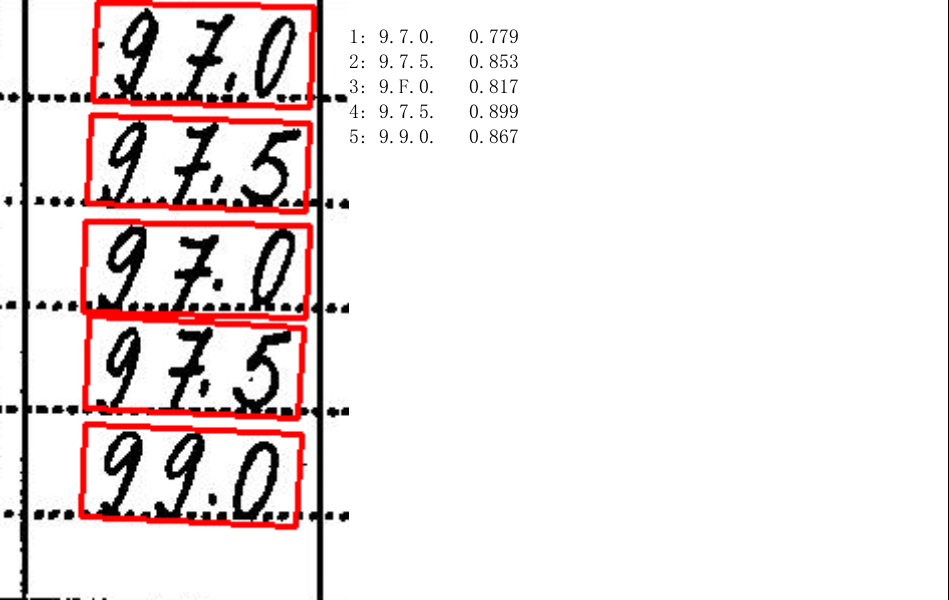

In [19]:
for idx in range (len(result)):
    res = result[idx]
    for line in res:
        print(line)

# draw result
from PIL import Image
result = result[0]
image_ocr = Image.open(test_clipped_image_path).convert('RGB')
boxes = [line[0] for line in result]
txts = [line[1][0] for line in result]
scores = [line[1][1] for line in result]
im_show = draw_ocr(image_ocr, boxes, txts, scores, font_path='./Fonts/simfang.ttf')
im_show = Image.fromarray(im_show)
im_show.save('ocr_result.jpg')
im_show

## 4. Perform OCR and save in Excel Workbook

In [20]:

# Create an Excel workbook and add a worksheet
wb = Workbook()
ws = wb.active
ws.title = 'OCR_Results'


save_folder = './output'

# Indentifying the cells 
boxes = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    
    # Calculate a factor to increase the bounding box area (e.g., 80% larger)
    increase_factor = 0.8  # Modify this factor as needed
    
    x -= int(w * increase_factor)  # Increase width
    #y -= int(h * increase_factor)  # Increase height
    w += int(2 * w * increase_factor)  # Increase width
    #h += int(2 * h * increase_factor)  # Increase height
    
    if (w<1000 and h<500):
        
        image_with_contours = cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
        boxes.append([x,y,w,h])
        
        # Crop each cell using the bounding rectangle coordinates
        ROI = image[y:y+h, x:x+w]
        cv2.imwrite('clipped.png', ROI)
        
        ocr_result = ocr.ocr('clipped.png', cls = True)
        if ocr_result is not None and ocr_result[0] is not None:
            cell_values = ocr_result[0]
            text_in_cells = [line[1][0] for line in cell_values]

            for text in range(len(text_in_cells)):
                value =  text_in_cells[text]
                cell_column = openpyxl.utils.get_column_letter(x//100)  # Assuming x-coordinate translates to columns
                cell_row = y//100  # Assuming y-coordinate translates to rows
                
                # Convert the column letter to its corresponding index
                col_index = openpyxl.utils.column_index_from_string(cell_column)
                
                # Write the OCR value to the cell in the Excel sheet
                cell = ws.cell(row=int(cell_row) + text, column=col_index)
                cell.value = value
        else:
            print('No values detected in clip')
        
wb.save('Excel_with_OCR_Results.xlsx') 
        

[2023/12/15 17:07:06] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.016109228134155273
[2023/12/15 17:07:06] ppocr DEBUG: cls num  : 0, elapsed : 0
[2023/12/15 17:07:06] ppocr DEBUG: rec_res num  : 0, elapsed : 1.1920928955078125e-06
No values detected in clip
[2023/12/15 17:07:06] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.014184713363647461
[2023/12/15 17:07:06] ppocr DEBUG: cls num  : 0, elapsed : 0
[2023/12/15 17:07:06] ppocr DEBUG: rec_res num  : 0, elapsed : 9.5367431640625e-07
No values detected in clip
[2023/12/15 17:07:06] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.014130830764770508
[2023/12/15 17:07:06] ppocr DEBUG: cls num  : 0, elapsed : 0
[2023/12/15 17:07:06] ppocr DEBUG: rec_res num  : 0, elapsed : 9.5367431640625e-07
No values detected in clip
[2023/12/15 17:07:06] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.013966798782348633
[2023/12/15 17:07:06] ppocr DEBUG: cls num  : 0, elapsed : 0
[2023/12/15 17:07:06] ppocr DEBUG: rec_res num  : 0, elapsed : 1.1920928955078125e-06
N

### Current findings

In [ ]:
# Even though the excel is produced, the cells are not in the correct order. This could be due to the bigger cell detection (comprising of more than one value, yet still using coordinated onf the boundary lines) thus the disorienting the excel output 

### Next steps

In [18]:
# 1. Adjust the thresholds of the vertical and horizontal lile detected inorder to narrow down to single cells before OCR. OR Make use of layout analysis and tabel recognition tool of PaddleOCR, here: https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.7/ppstructure/docs/quickstart_en.md

# 2. Use the orginal image/processed image coordinates & boundary box coordinates to correclty place the trancsribed text in its respective cell in Ms Excel
